In [198]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [43]:
sents_raw = pd.read_csv("processed_sentences_checked.csv")
orig_sents = np.unique(sents_raw["original"])

In [302]:
# delete duplicates and calculate model preference based on perplexity
sents = sents_raw.drop_duplicates(subset=['original','transformed'])
sents.loc[(sents['original_perplexity']<sents['transformed_perplexity']),'perplexity_preference'] = 2
sents.loc[(sents['original_perplexity']>sents['transformed_perplexity']),'perplexity_preference'] = 1

/Users/jchenxy/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [146]:
# add sentence ID 
for idx in range(len(orig_sents)):
    orig_sent = orig_sents[idx]
    sents.loc[(sents['original']==orig_sent),'sent_id'] = str(idx)

In [166]:
# convert the data frame to long form
orig = sents[['original','original_perplexity','original_word_nll','original_token_nll','sent_id']].drop_duplicates()
orig['sent_type'] = 'original'
orig = orig.rename(columns={'original':'sent','original_perplexity':'perplexity','original_word_nll':'word_nll','original_token_nll':'token_nll'})
transformed = sents[['transformed','transformed_perplexity','transformed_word_nll','transformed_token_nll','sent_id']].drop_duplicates()
transformed['sent_type'] = 'transformed'
transformed = transformed.rename(columns={'transformed':'sent','transformed_perplexity':'perplexity','transformed_word_nll':'word_nll','transformed_token_nll':'token_nll'})
df_long = pd.concat([orig,transformed],ignore_index=True)

Text(0.5, 0, 'sentence type')

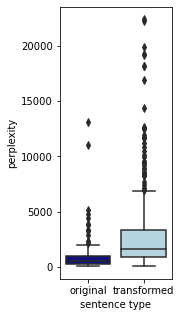

In [282]:
# plot perplexity scores based on sentence types
plt.figure(figsize=(2,5))
sns.boxplot(data=full_perplex, x="sent_type", y="perplexity", palette=['darkblue', 'lightblue'])
plt.xlabel('sentence type')

In [314]:
# calculate proportion preference with the two methods
sents_preference = sents.copy()
pref_df = pd.DataFrame()
llama_pref_orig = np.sum(sents_preference['llama_preference']==2) / len(sents_preference.index)
total_llama_pref = np.sum(sents_preference['llama_preference'].isin([1,2])) / len(sents_preference.index)
perplex_pref_orig = np.sum(sents_preference['perplexity_preference']==2) / len(sents_preference.index)
pref_df['pref_type'] = ['prompt','perplexity']
pref_df['preference'] = [llama_pref_orig, perplex_pref_orig]
pref_df['total'] = [total_llama_pref,1]
pref_df['missing_total'] = [1,1]
print(pref_df)

    pref_type  preference     total  missing_total
0      prompt    0.557047  0.834452              1
1  perplexity    0.845638  1.000000              1


[]

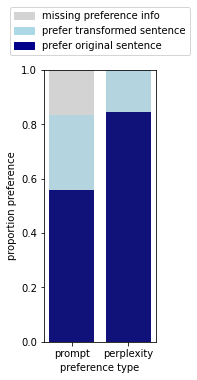

In [301]:
# plot sentence preference
plt.figure(figsize=(2, 5))
bar3 = sns.barplot(x='pref_type',y='missing_total',data=pref_df,color='lightgray')
bar2 = sns.barplot(x='pref_type',y='total',data=pref_df,color='lightblue')
bar1 = sns.barplot(x='pref_type',y='preference',data=pref_df,color='darkblue')
plt.ylim(0,1)
top_bar = mpatches.Patch(color='darkblue', label='prefer original sentence')
bottom_bar = mpatches.Patch(color='lightblue', label='prefer transformed sentence')
back_bar = mpatches.Patch(color='lightgray', label='missing preference info')
plt.xlabel('preference type')
plt.ylabel('proportion preference')
plt.legend(handles=[back_bar,bottom_bar,top_bar],loc='upper center',bbox_to_anchor=(0.5, 1.25))
plt.plot()

In [202]:
# calculate sentence characteristics
for index, row in df_long.iterrows():
    words = re.findall(r'\'[\u4e00-\u9fff|a-zA-Z]+\'',row['word_nll'])
    tokens = re.findall(r'\'[\u4e00-\u9fff|a-zA-Z]+\'',row['token_nll'])
    df_long.loc[df_long.index==index,'word_len'] = len(words)
    df_long.loc[df_long.index==index,'token_len'] = len(tokens)
    chn_word_count = 0
    chn_token_count = 0
    cs_count = -1
    curr_token = ''
    for word in words:
        if len(re.findall(r'[\u4e00-\u9fff]+',word))>0:
            chn_word_count += 1
    for token in tokens:
        prev_token = curr_token
        if len(re.findall(r'[\u4e00-\u9fff]+',token))>0:
            chn_token_count += 1
            curr_token = 'chn'
        else:
            curr_token = 'eng'
        if curr_token != prev_token:
            cs_count += 1
    df_long.loc[df_long.index==index,'chn_word_len'] = chn_word_count
    df_long.loc[df_long.index==index,'chn_token_len'] = chn_token_count
    df_long.loc[df_long.index==index,'cs_count'] = cs_count
df_long['eng_word_len'] = df_long['word_len'] - df_long['chn_word_len']
df_long['eng_token_len'] = df_long['token_len'] - df_long['chn_token_len']
df_long['prop_chn_word'] = df_long['chn_word_len'] / df_long['word_len']
df_long['prop_chn_token'] = df_long['chn_token_len'] / df_long['token_len']

In [315]:
df_long.to_csv('df_long.csv', index=False)

In [200]:
md = smf.mixedlm("perplexity ~ sent_type", df_long, groups=df_long["sent_id"])
mdf = md.fit()
print(mdf.summary())

                   Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      perplexity  
No. Observations:        547          Method:                  REML        
No. Groups:              100          Scale:                   6017706.2734
Min. group size:         2            Log-Likelihood:          -5108.5203  
Max. group size:         6            Converged:               Yes         
Mean group size:         5.5                                               
---------------------------------------------------------------------------
                            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
---------------------------------------------------------------------------
Intercept                   1134.932  317.492 3.575 0.000  512.659 1757.204
sent_type[T.transformed]    1737.268  272.226 6.382 0.000 1203.715 2270.821
Group Var                4062406.670  338.035                              



In [207]:
md = smf.mixedlm("perplexity ~ token_len * prop_chn_token * cs_count", df_long, groups=df_long["sent_id"])
mdf = md.fit()
print(mdf.summary())

                         Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           perplexity  
No. Observations:           547               Method:                       REML        
No. Groups:                 100               Scale:                        5633958.6632
Min. group size:            2                 Log-Likelihood:               -5024.2488  
Max. group size:            6                 Converged:                    Yes         
Mean group size:            5.5                                                         
----------------------------------------------------------------------------------------
                                     Coef.    Std.Err.   z    P>|z|   [0.025     0.975] 
----------------------------------------------------------------------------------------
Intercept                           13170.745 5066.257  2.600 0.009   3241.064 23100.425
token_len                           -1388.959  

In [209]:
df_long_word = df_long.dropna()
md = smf.mixedlm("perplexity ~ word_len * prop_chn_word * cs_count", df_long_word, groups=df_long_word["sent_id"])
mdf = md.fit()
print(mdf.summary())

                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          perplexity  
No. Observations:           391              Method:                      REML        
No. Groups:                 95               Scale:                       6575522.3073
Min. group size:            1                Log-Likelihood:              -3613.2142  
Max. group size:            6                Converged:                   Yes         
Mean group size:            4.1                                                       
--------------------------------------------------------------------------------------
                                   Coef.    Std.Err.   z    P>|z|   [0.025     0.975] 
--------------------------------------------------------------------------------------
Intercept                          5932.601 5253.316  1.129 0.259  -4363.709 16228.910
word_len                           -521.282  658.846 -0.791 0.429  -

In [225]:
df_long.groupby(by=["sent_type"]).mean()

,perplexity,word_len,token_len,chn_word_len,chn_token_len,cs_count,eng_word_len,eng_token_len,prop_chn_word,prop_chn_token
sent_type,,,,,,,,,,
original,1134.931524,4.84000,8.910000,3.670000,7.250000,1.900000,1.170000,1.660000,0.740581,0.796966
transformed,2787.099754,7.14094,10.038031,4.776286,7.995526,3.281879,2.364653,2.042506,0.653748,0.786434


In [312]:
df_long.groupby(by=["sent_type"]).std()

,perplexity,word_len,token_len,chn_word_len,chn_token_len,cs_count,eng_word_len,eng_token_len,prop_chn_word,prop_chn_token
sent_type,,,,,,,,,,
original,1908.103839,4.398622,3.197521,3.635001,2.992837,1.141504,1.303104,0.843514,0.162652,0.107649
transformed,3353.963143,4.807067,3.179373,3.542069,2.924303,1.387390,1.735647,0.881031,0.136602,0.087900


In [229]:
orig_sent_df = df_long.loc[(df_long['sent_type']=='original')]
transformed_sent_df = df_long.loc[(df_long['sent_type']=='transformed')]
for col in df_long.columns:
    if df_long[col].dtype==float:
        orig_var = orig_sent_df[col]
        transformed_var = transformed_sent_df[col]
        print(col)
        print(stats.ttest_ind(orig_var, transformed_var))

perplexity
Ttest_indResult(statistic=-4.754679000389787, pvalue=2.5473979892834987e-06)
word_len
Ttest_indResult(statistic=-4.392383294594424, pvalue=1.3474894946683257e-05)
token_len
Ttest_indResult(statistic=-3.2039711046552517, pvalue=0.001434709273001547)
chn_word_len
Ttest_indResult(statistic=-2.8098538676106473, pvalue=0.005134468988653864)
chn_token_len
Ttest_indResult(statistic=-2.294762903080123, pvalue=0.022125903376464008)
cs_count
Ttest_indResult(statistic=-9.280333110196677, pvalue=3.961252668234697e-19)
eng_word_len
Ttest_indResult(statistic=-6.484425433518211, pvalue=1.9989246264720793e-10)
eng_token_len
Ttest_indResult(statistic=-3.954755349608396, pvalue=8.672303376766915e-05)
prop_chn_word
Ttest_indResult(statistic=nan, pvalue=nan)
prop_chn_token
Ttest_indResult(statistic=1.0370511515674463, pvalue=0.3001719162430153)


In [230]:
orig_sent_df = df_long_word.loc[(df_long['sent_type']=='original')]
transformed_sent_df = df_long_word.loc[(df_long['sent_type']=='transformed')]
for col in df_long.columns:
    if df_long[col].dtype==float:
        orig_var = orig_sent_df[col]
        transformed_var = transformed_sent_df[col]
        print(col)
        print(stats.ttest_ind(orig_var, transformed_var))

perplexity
Ttest_indResult(statistic=-4.015569300990029, pvalue=7.117600672139957e-05)
word_len
Ttest_indResult(statistic=-4.288169385326435, pvalue=2.2749843023724198e-05)
token_len
Ttest_indResult(statistic=-3.45360362399919, pvalue=0.0006139748824131888)
chn_word_len
Ttest_indResult(statistic=-0.950516969072653, pvalue=0.3424398110138829)
chn_token_len
Ttest_indResult(statistic=-2.4139777821896833, pvalue=0.016240444627490223)
cs_count
Ttest_indResult(statistic=-9.078162050509524, pvalue=5.608998270174304e-18)
eng_word_len
Ttest_indResult(statistic=-7.489995105394215, pvalue=4.669120593611115e-13)
eng_token_len
Ttest_indResult(statistic=-4.377550226833764, pvalue=1.5443663206514657e-05)
prop_chn_word
Ttest_indResult(statistic=4.3932937099115, pvalue=1.441529048809782e-05)
prop_chn_token
Ttest_indResult(statistic=1.0786578093665211, pvalue=0.2814086877149193)
